In [ ]:
'''
Regex pattern
xoá tất cả dấu () và char bên trong: \([^)]+\)
xoá tất cả kí tự đặc biệt: [\\"#%&'\-\/:;<=>@_`~!^$.*+?()[\]{}|] # nhớ không bỏ white space và dấu phẩy và dấu _ nếu tokenize trước
'''

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import thư viện

In [2]:
%cd /content/drive/MyDrive/Colab_Notebooks/word_recommendation

/content/drive/MyDrive/Colab_Notebooks/word_recommendation


In [3]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 32.2 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import numpy as np
import regex as re
import pickle
from pyvi import ViTokenizer, ViPosTagger
import pandas as pd

# Tiền xử lí dữ liệu

## Regex

In [7]:
# # Testing regex pattern
# text = "Bên cạnh đó, CTĐT cử nhân ngành X được hỗ trợ, phục vụ bởi đội ngũ chuyên viên, \
# nhân viên có kiến thức chuyên môn, có kỹ năng làm việc chuyên nghiệp của Khoa và Trường \
# gồm các GV, chuyên viên hành chính của Khoa, chuyên viên các phòng/bộ phận như Trung tâm Công nghệ thông tin (X), \
# Phòng Quản lý Đào tạo (P.QLĐT), Phòng Hành chính tổng hợp (P.HCTH),1234567890 \\#%&'\-/:;<=>@_`~!^$.*+?[\]{}|"

# # Define a regex pattern to match special characters, including backslashes
# pattern = r'[1234567890#%&\'\-/:;<=>@_`~!^$,.*+?[\]{}|\\]|\([^)]+\)'

# # Remove the special characters using regex
# cleaned_text = re.sub(pattern, '', text)

# # Print the cleaned text
# # print(cleaned_text)


In [5]:
# Chạy real

# file_path = "/content/drive/MyDrive/Colab_Notebooks/word_recommendation/NextWordPredictor_1/small_recommedation_6_9_2023.txt"
file_path = "/content/drive/MyDrive/Colab_Notebooks/word_recommendation/NextWordPredictor_1/data_for_recommed_word_6_9_2023.txt"
# đọc file
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()
split_data = text.split('\n')
split_data

# xoá kí tự đặc biệt
pattern = r'[1234567890#%&\'\-/:;<=>@_`~!^$,.*+?[\]{}|\\]|\([^)]+\)'
def delete_special_char(data, pattern):
  clean_data = [re.sub(pattern,  '', line) for line in data]
  return clean_data

cleaned_data = delete_special_char(split_data, pattern)
# type(cleaned_data)

# Tokenizing
def tokenize_pyvi(data):
  tokenized_sentences = [ViTokenizer.tokenize(sentence) for sentence in data]
  return tokenized_sentences

tokenized_sentences = tokenize_pyvi(cleaned_data)
# tokenized_sentences # kết quả

## Chuyển tokenized data thành format để train model

In [6]:
# cách của Q có thể sẽ bỏ
# def tokenize_pyvi_Quan(data):
#   tokenized_sentences = [ViTokenizer.tokenize(sentence) for sentence in data]
#   return tokenized_sentences

def tokenize_pyvi_Vinh(data):
  tokenized_sentences = [ViTokenizer.tokenize(sentence).split() for sentence in data]
  return  tokenized_sentences

tokenized_sentences = tokenize_pyvi_Vinh(cleaned_data)
len(tokenized_sentences)

3314

In [7]:
# chuyển đổi thành sequence(số)/đánh index cho từng token
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(tokenized_sentences)
seq = tokenizer.texts_to_sequences(tokenized_sentences)

In [8]:
X = []
y = []
total_words_dropped = 0

for i in seq:
    if len(i) > 1:
        for index in range(1, len(i)):
            X.append(i[:index])
            y.append(i[index])
    else:
        total_words_dropped += 1
print("Total Single Words Dropped are:", total_words_dropped)
# Dữ liệu đã có thể đem train
print(f'Dữ liệu training sẵn sàng')
print(f'Dữ liệu testing sẵn sàng')
# cho model fit X và y

Total Single Words Dropped are: 79
Dữ liệu training sẵn sàng
Dữ liệu testing sẵn sàng


In [9]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=25) # vá những chỗ trống với [0] để các input đều có length bằng nhau / độ dài mặc định sẽ là chiều dài của câu dài nhất
y = tf.keras.utils.to_categorical(y) # đổi từ vector(interger) thành binary class matrix
vocab_size = len(tokenizer.word_index) + 1 # vocab size + 1 vì trong đó 1 giá trị OOV(out of vocab)

# Chạy model

<Axes: >

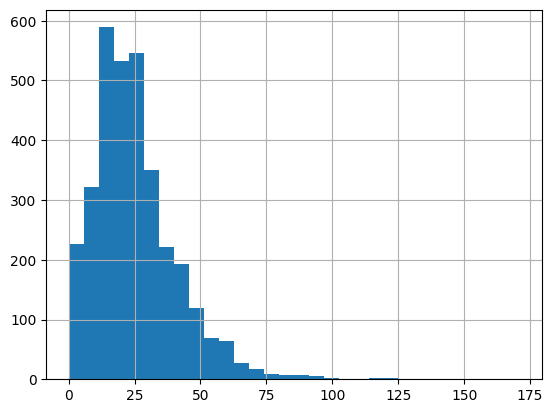

In [10]:
# xác định input_length
seq_len = [len(sentence) for sentence in tokenized_sentences]
pd.Series(seq_len).hist(bins=30)

In [42]:
input_dim = vocab_size # độ dài của những từ riêng biệt
output_dim = 128
input_length = X.shape[-1]
dropout_threshold = 0.5

model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length),
    tf.keras.layers.Bidirectional(LSTM(units=output_dim, dropout= dropout_threshold, return_sequences=True), merge_mode='concat'),
    tf.keras.layers.Bidirectional(LSTM(units=output_dim, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='sigmoid')
])

adam = Adam(learning_rate=0.001)
model1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=tf.keras.metrics.CategoricalAccuracy(
    name='categorical_accuracy', dtype=None))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25, 128)           97024     
                                                                 
 bidirectional_6 (Bidirecti  (None, 25, 256)           263168    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 25, 256)           394240    
 onal)                                                           
                                                                 
 global_average_pooling1d_3  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                      

In [44]:
model1.fit(X,y, batch_size=128, epochs=200, shuffle=True)

Epoch 1/200
22/22 [==============================] - 1s 34ms/step - loss: 3.9473 - categorical_accuracy: 0.1001
Epoch 2/200
22/22 [==============================] - 1s 24ms/step - loss: 3.8986 - categorical_accuracy: 0.0957
Epoch 3/200
22/22 [==============================] - 0s 14ms/step - loss: 3.8542 - categorical_accuracy: 0.1085
Epoch 4/200
22/22 [==============================] - 0s 20ms/step - loss: 3.8504 - categorical_accuracy: 0.1059
Epoch 5/200
22/22 [==============================] - 0s 13ms/step - loss: 3.7959 - categorical_accuracy: 0.1023
Epoch 6/200
22/22 [==============================] - 0s 23ms/step - loss: 3.7628 - categorical_accuracy: 0.1103
Epoch 7/200
22/22 [==============================] - 0s 22ms/step - loss: 3.7028 - categorical_accuracy: 0.1133
Epoch 8/200
22/22 [==============================] - 0s 22ms/step - loss: 3.6737 - categorical_accuracy: 0.1136
Epoch 9/200
22/22 [==============================] - 0s 14ms/step - loss: 3.6719 - categorical_accuracy:

In [50]:
model1.save('word_recommendation_Quan.h5')
# model = tf.keras.models.load_model('word_recommendation_2.h5')

In [46]:
# 1 dictionary chứa value và index
words_index = tokenizer.word_index
# words_index

In [57]:
words_index['nhưng']

622

In [48]:
ListOfWord = np.array(list(tokenizer.word_index.keys())) # chuyển tất cả vocab thành 1 list duy nhất
# ListOfWord

In [58]:
#TODO: chỉnh lại từ đây
def make_prediction_second(text, n_predict_words):
  for i in range(n_predict_words):
    tokenized_input = (ViTokenizer.tokenize(text)).split()
    text_indexing = [words_index[token] for token in tokenized_input if token in words_index]
    # text_tokenize = tokenizer.texts_to_sequences([tokenized_input]) # tokenizer đang sủ dụng của tensorflow không phải của pyvi, in thử ra, text không bị lowercase
    #cần xem lại output để đưa vào pad_sequence là gì, chạy lại hướng dẫn
    text_padded = tf.keras.preprocessing.sequence.pad_sequences([text_indexing], maxlen=X.shape[-1])
    prediction = np.squeeze(np.argmax(model1.predict(text_padded), axis=-1))
    prediction = str(ListOfWord[prediction - 1])
    text += " " + prediction
  return text
  # print(f'từ đã được tokenize', tokenized_input)
  # print(f'các từ được đánh số', text_indexing)
  # print(f'các từ được padded', text_padded)
  # print(text_tokenize

In [59]:
make_prediction_second("đánh_giá theo sinh viên", 10)

1/1 [==============================] - 0s 33ms/step


'đánh_giá theo sinh viên những đào_tạo quy_hoạch giảng giảng viênsv do bộ gdđt quy_định'

In [45]:
def make_prediction_first(text, n_words):
    for i in range(n_words):
        text_tokenize = tokenizer.texts_to_sequences([text])
        text_padded = tf.keras.preprocessing.sequence.pad_sequences(text_tokenize, maxlen=80)
        prediction = np.squeeze(np.argmax(model.predict(text_padded), axis=-1))
        prediction = str(tokenized_sentences[prediction - 1])
    #     print(vocab_array[np.argsort(model.predict(text_padded)) - 1].ravel()[:-3])
    #     text += " " + prediction
    # return text
    # print(prediction)
    print(text_padded)

In [ ]:

text = "công bố công khai trên website"
next_words = 3
def predict_words_Vinh(text, n_predict_words):
  for _ in range(next_words):
      token_list = tokenizer.texts_to_sequences([text])[0]
      token_list = pad_sequences(
          [token_list], maxlen=max_sequence_len - 1, padding='pre')
      predicted_probs = model.predict(token_list)
      predicted_word = tokenizer.index_word[np.argmax(predicted_probs)]
      text += " " + predicted_word

  print("Next predicted words:", text)

In [24]:
index = [19, 20, 21]
list_index = list(index)
list_index


[19, 20, 21]

In [ ]:
# # text_11 = ViTokenizer.tokenize("đánh_giá theo sinh viên")
# text_11 = "đánh giá theo sinh viên"
# splited_text = (ViTokenizer.tokenize(text_11)).split()
# # print(splited_text)
# splited_text


array_11 = ['đánh_giá', 'theo', 'sinh_viên']
for i in range(len(array_11)):


['đánh_giá', 'theo', 'sinh_viên']

In [ ]:
token_to_index["báo_cáo"]

17